Below is from https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/274970. This document dedicates to understanding the method used to "recover" time series. 

In [2]:
import glob

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale


def calc_price_from_tick(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path,
                         columns=[
                             'time_id',
                             'ask_price1',
                             'ask_price2',
                             'bid_price1',
                             'bid_price2'
                         ])
    df = df.groupby('time_id') \
        .apply(calc_price_from_tick, include_groups=False).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


From here go to [section](#section) 'Recovering time_id order' to recover the time_id order in one go. 

In [3]:
# Added 'sorted' for consistent ordering between computers
paths = sorted(glob.glob('../raw_data/kaggle_ORVP/book_train.parquet/**/*.parquet'))

df_files = pd.DataFrame(
        {'book_path': paths}) \
        .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',
              engine='python')

In [4]:
df_files

,book_path,stock_id
0,../raw_data/kaggle_ORVP/book_train.parquet/sto...,0
1,../raw_data/kaggle_ORVP/book_train.parquet/sto...,1
2,../raw_data/kaggle_ORVP/book_train.parquet/sto...,10
3,../raw_data/kaggle_ORVP/book_train.parquet/sto...,100
4,../raw_data/kaggle_ORVP/book_train.parquet/sto...,101
...,...,...
107,../raw_data/kaggle_ORVP/book_train.parquet/sto...,95
108,../raw_data/kaggle_ORVP/book_train.parquet/sto...,96
109,../raw_data/kaggle_ORVP/book_train.parquet/sto...,97
110,../raw_data/kaggle_ORVP/book_train.parquet/sto...,98


In [5]:
# Changed 'n_jobs' from 4 to -1 (uses all processors except for one)
df_prices = pd.concat(
        Parallel(n_jobs=-1)(
            delayed(calc_prices)(r) for _, r in df_files.iterrows()
        )
    )

In [6]:
df_prices

,time_id,price,stock_id
0,5,193.732285,0
1,11,199.254349,0
2,16,209.192215,0
3,31,216.201233,0
4,62,214.542404,0
...,...,...,...
3825,32751,67.704666,99
3826,32753,65.535995,99
3827,32758,61.342651,99
3828,32763,80.197014,99


In [7]:
df_prices = df_prices.pivot(index='time_id', columns='stock_id', values='price')

In [8]:
df_prices

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
time_id,,,,,,,,,,,,,,,,,,,,,
5,193.732285,152.520142,123.543564,226.108032,621.378357,742.354675,371.177338,246.000229,284.359589,238.991669,...,88.208282,246.723755,211.299942,66.260727,96.310081,142.421188,108.379944,84.392433,53.396614,310.689178
11,199.254349,149.529556,128.659622,250.406204,616.809387,769.597046,413.231903,256.925201,278.691284,244.565826,...,90.297180,275.941040,213.995102,63.072239,101.311691,137.068756,105.517082,91.180519,55.886795,301.748474
16,209.192215,104.988831,118.818810,164.805649,534.306213,586.615906,236.966324,208.154037,123.725777,177.724747,...,70.051003,189.787506,281.025391,53.532917,74.565399,93.414337,77.457138,55.079498,53.092453,194.631271
31,216.201233,137.857147,138.425873,236.298813,660.520325,806.596924,360.026093,261.327332,194.631271,232.693695,...,90.736702,257.319244,235.635056,61.275440,90.982735,134.865082,103.755196,92.487404,58.133110,259.709229
62,214.542404,140.748459,137.293091,238.312729,640.351746,769.597046,403.298462,250.780502,188.085373,243.854874,...,89.145676,248.183670,231.729492,59.578182,87.977013,125.484039,103.563057,96.089439,57.377617,259.709229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32751,192.399261,148.998367,132.208160,243.854874,655.359985,748.982849,390.167816,252.668915,252.668915,230.456253,...,88.580864,269.730164,242.445312,60.090313,93.466385,135.737991,103.563057,94.201096,56.833385,307.275024
32753,200.205444,143.640549,128.857269,245.280930,619.085449,755.730408,390.167816,250.406204,258.907654,241.746628,...,91.230103,269.730164,213.450577,62.091843,92.794334,136.622284,104.077019,87.930901,55.998718,290.263245
32758,198.782181,111.997437,142.784821,217.321442,594.936707,729.444153,511.500488,234.318649,132.731140,206.108307,...,80.350647,225.500214,212.369812,43.965450,80.582207,111.254745,89.910049,81.127731,56.603291,202.623383


In [12]:
# 'n_iter' was replaced by 'max_iter' in sklearn >= 1.5
clf = TSNE(
        n_components=1,
        perplexity=400,
        random_state=0,
        max_iter=2000     
    )
compressed = clf.fit_transform(
        pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
    )

In [13]:
compressed

array([[ 29.569765],
       [ 26.617657],
       [-10.507812],
       ...,
       [  9.322571],
       [-17.611984],
       [ -4.091877]], dtype=float32)

In [14]:
compressed.shape

(3830, 1)

In [15]:
order = np.argsort(compressed[:, 0])

In [16]:
order

array([ 522, 3740, 3707, ..., 3455, 3764, 1287])

In [17]:
df_prices[0].iloc[522]

np.float32(194.18074)

In [18]:
ordered=df_prices.set_index(order)

In [19]:
ordered

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
522,193.732285,152.520142,123.543564,226.108032,621.378357,742.354675,371.177338,246.000229,284.359589,238.991669,...,88.208282,246.723755,211.299942,66.260727,96.310081,142.421188,108.379944,84.392433,53.396614,310.689178
3740,199.254349,149.529556,128.659622,250.406204,616.809387,769.597046,413.231903,256.925201,278.691284,244.565826,...,90.297180,275.941040,213.995102,63.072239,101.311691,137.068756,105.517082,91.180519,55.886795,301.748474
3707,209.192215,104.988831,118.818810,164.805649,534.306213,586.615906,236.966324,208.154037,123.725777,177.724747,...,70.051003,189.787506,281.025391,53.532917,74.565399,93.414337,77.457138,55.079498,53.092453,194.631271
687,216.201233,137.857147,138.425873,236.298813,660.520325,806.596924,360.026093,261.327332,194.631271,232.693695,...,90.736702,257.319244,235.635056,61.275440,90.982735,134.865082,103.755196,92.487404,58.133110,259.709229
3495,214.542404,140.748459,137.293091,238.312729,640.351746,769.597046,403.298462,250.780502,188.085373,243.854874,...,89.145676,248.183670,231.729492,59.578182,87.977013,125.484039,103.563057,96.089439,57.377617,259.709229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,192.399261,148.998367,132.208160,243.854874,655.359985,748.982849,390.167816,252.668915,252.668915,230.456253,...,88.580864,269.730164,242.445312,60.090313,93.466385,135.737991,103.563057,94.201096,56.833385,307.275024
1852,200.205444,143.640549,128.857269,245.280930,619.085449,755.730408,390.167816,250.406204,258.907654,241.746628,...,91.230103,269.730164,213.450577,62.091843,92.794334,136.622284,104.077019,87.930901,55.998718,290.263245
3455,198.782181,111.997437,142.784821,217.321442,594.936707,729.444153,511.500488,234.318649,132.731140,206.108307,...,80.350647,225.500214,212.369812,43.965450,80.582207,111.254745,89.910049,81.127731,56.603291,202.623383
3764,208.154037,81.363800,116.025002,107.271202,517.815308,505.337830,143.150299,182.758347,94.254021,162.255463,...,59.241581,151.418915,263.792694,44.834888,66.788277,77.385681,72.005219,52.135536,50.201122,151.967529


In [20]:
if ordered[61].iloc[0] > ordered[61].iloc[-1]:
        ordered = ordered.reindex(ordered.index[::-1])\
            .reset_index(drop=True)

## section

Recovering time_id order

Below is the full function, run it to "recover" the time series. I corrected some bugs so that it runs. 

In [9]:
def reconstruct_time_id_order():
    # Added 'sorted' for consistent ordering between computers
    paths = sorted(glob.glob('../raw_data/kaggle_ORVP/book_train.parquet/**/*.parquet'))

    df_files = pd.DataFrame(
        {'book_path': paths}) \
        .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',
              engine='python')

    # build price matrix using tick-size
    # Changed 'n_jobs' from 4 to -1 (uses all processors except for one)
    df_prices = pd.concat(
        Parallel(n_jobs=-1)(
            delayed(calc_prices)(r) for _, r in df_files.iterrows()
        )
    )
    df_prices = df_prices.pivot(index='time_id', columns='stock_id', values='price')

    # t-SNE to recovering time-id order
    # 'n_iter' was replaced by 'max_iter' in sklearn >= 1.5
    clf = TSNE(
        n_components=1,
        perplexity=400,
        random_state=0,
        max_iter=2000
    )
    compressed = clf.fit_transform(
        pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
    )

    order = np.argsort(compressed[:, 0])
    ordered=df_prices.set_index(order)

    # correct direction of time-id order using known stock (id61 = AMZN)
    if ordered[61].iloc[0] > ordered[61].iloc[-1]:
        ordered = ordered.reindex(ordered.index[::-1])\
            .reset_index(drop=True)

    return ordered.index

time_order=reconstruct_time_id_order()

Notice that the list time_order is actually a list of index for df_price with recovered order. 

In [10]:
time_order

Index([ 522, 3740, 3707,  687, 3495, 2664, 1574, 2044, 2436, 1427,
       ...
       3406, 1384, 1624, 1232, 1248, 2962, 1852, 3455, 3764, 1287],
      dtype='int64', length=3830)

In [11]:
recovered_time_id_order=[int(df_prices.index[id]) for id in time_order]

Above is now stored in proj_mod/recover_time_id.py: 

In [12]:
import sys
sys.path.append("../")

from proj_mod import data_processing, recover_time_id

In [14]:
recovered_time_id_order_list = recover_time_id.reconstruct_time_id_order(str_path="../raw_data/kaggle_ORVP/book_train.parquet")

In [16]:
# Converts to numpy array and save it
recovered_time_id_order = np.array(recovered_time_id_order_list, dtype=int)
np.save('../processed_data/recovered_time_id_order.npy',recovered_time_id_order)
recovered_time_id_order

array([ 4294, 31984, 31570, ..., 29316, 32195, 10890])

In [17]:
# Loads the saved array
recovered_time_id_order_loaded = np.load('../processed_data/recovered_time_id_order.npy')
recovered_time_id_order_loaded

array([ 4294, 31984, 31570, ..., 29316, 32195, 10890])

In [18]:
ordered_stock_4=df_prices[4].loc[recovered_time_id_order]

In [19]:
ordered_stock_4.values

array([487.70975, 484.89062, 482.1039 , ..., 635.5006 , 635.5006 ,
       640.35175], dtype=float32)

In [20]:
ordered_stock_4

time_id
4294     487.709747
31984    484.890625
31570    482.103912
5666     484.890625
29740    484.890625
            ...    
24913    640.351746
15365    635.500610
29316    635.500610
32195    635.500610
10890    640.351746
Name: 4, Length: 3830, dtype: float32

In [21]:
import matplotlib.pyplot as plt

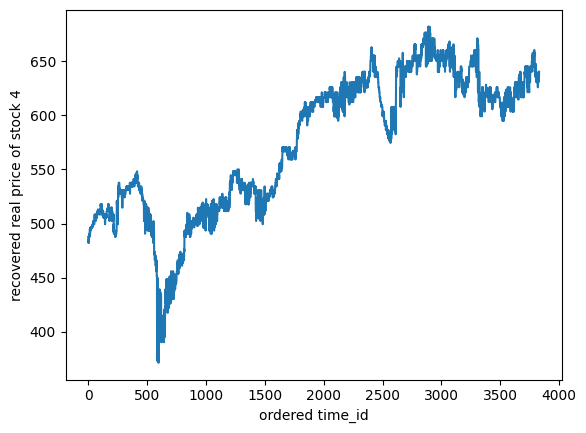

In [22]:
plt.plot(range(len(ordered_stock_4)),ordered_stock_4)
plt.xlabel("ordered time_id")
plt.ylabel("recovered real price of stock 4")
plt.show()

Now we can create the time series CV split. 

In [23]:
timecv=data_processing.time_cross_val_split(list_time=recovered_time_id_order)

In fold 0 :

Train set end at 10433 .

Test set start at 5676 end at 26678 .

In fold 1 :

Train set end at 26678 .

Test set start at 16479 end at 13594 .

In fold 2 :

Train set end at 13594 .

Test set start at 8662 end at 8117 .

In fold 3 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



Following is a double check: 

In [24]:
for fold_id, (train_index,test_index) in timecv:
    print("In fold",int(fold_id),":\n")
    print("Train set start at",train_index[0],"and end at",train_index[-1],".\n")
    print("Test set start at",test_index[0],"end at",test_index[-1],".\n")

In fold 0 :

Train set start at 4294 and end at 10433 .

Test set start at 5676 end at 26678 .

In fold 1 :

Train set start at 4294 and end at 26678 .

Test set start at 16479 end at 13594 .

In fold 2 :

Train set start at 4294 and end at 13594 .

Test set start at 8662 end at 8117 .

In fold 3 :

Train set start at 4294 and end at 8117 .

Test set start at 15516 end at 10890 .

